In [50]:
import numpy as np
import pandas as pd

from pathlib import Path
from src.evaluation.histogram_matching import hist_match
from src.dataset.tools.apply_rf import ApplyResponseFunction

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [51]:
def checkerboard(t1, t2, width=8):
    # produce a new tile that checkerboards the fixed tile and the ground truth tile
    
    # create structure
    cb_t1 = t1.copy()
    cb_t2 = t2.copy()
    
    # range for X and Y
    x_min, x_max = cb_t1[:, 0].min(), cb_t1[:, 0].max()
    y_min, y_max = cb_t1[:, 1].min(), cb_t1[:, 1].max()
    
    x_dist = x_max - x_min
    y_dist = y_max - y_min
    
    x_step_size = x_dist // width
    y_step_size = y_dist // width
    
    # create bins
    xr = np.arange(x_min, x_max, x_step_size)
    yr = np.arange(y_min, y_max, y_step_size)
    
    xr = np.concatenate((xr, np.array([x_max])))
    yr = np.concatenate((yr, np.array([y_max])))

    t1_indices = np.full(cb_t1.shape[0], False, dtype=bool)
    t2_indices = np.full(cb_t2.shape[0], False, dtype=bool)

    for i in range(len(xr)-1):
        for j in range(len(yr)-1):
            if (i + j) % 2 == 1:
                # 'white' tile --> t2
                new_indices = (
                    (cb_t2[:, 0] < xr[i+1]) &
                    (cb_t2[:, 0] >= xr[i]) &
                    (cb_t2[:, 1] < yr[j+1]) &
                    (cb_t2[:, 1] >= yr[j])
                )
                
                t2_indices = t2_indices | new_indices
                
            else:
                # 'black' tile --> gt
                new_indices = (
                    (cb_t1[:, 0] < xr[i+1]) &
                    (cb_t1[:, 0] >= xr[i]) &
                    (cb_t1[:, 1] < yr[j+1]) &
                    (cb_t1[:, 1] >= yr[j])
                )
                
                t1_indices = t1_indices | new_indices
                    

    return cb_t1[t1_indices], cb_t2[t2_indices]

In [52]:
# Setup some dirs
scan_files = Path("../dublin/npy/")
dataset_csv = "../150/test.csv"

# Synthetic corruption
ARF = ApplyResponseFunction("../dorf.json", "../mapping.npy")

# sampling
ss = 500000

# find overlapping scans from other examples
dataset = pd.read_csv(dataset_csv)
print(dataset.head())

   Unnamed: 0                                           examples  source_cam  \
0           0  /home/david/bin/python/intensity/src/dataset/n...          40   
1           1  /home/david/bin/python/intensity/src/dataset/n...           0   
2           2  /home/david/bin/python/intensity/src/dataset/n...          30   
3           3  /home/david/bin/python/intensity/src/dataset/n...          30   
4           4  /home/david/bin/python/intensity/src/dataset/n...          15   

   target_cam  target_intensity  
0           1               307  
1           0                55  
2          30               253  
3          30               342  
4          15               293  


In [53]:
scans = dataset.target_cam.unique()
print(scans)

[ 1  0 30 15 32 27 40 39 26]


In [54]:
ref_cam = 1
reference_scan = np.load(scan_files / f"{ref_cam}.npy")
ref_sample = np.random.choice(len(reference_scan), size=ss)
reference_scan = reference_scan[ref_sample, :4]  # don't need the whole thing

# make "altered" and "matched" columns
reference_scan = np.concatenate((
    reference_scan, 
    reference_scan[:, 3].reshape(-1, 1),
    reference_scan[:, 3].reshape(-1, 1)), axis=1)

print(reference_scan.shape)
full_scan = np.empty((0, 6))
full_scan = np.concatenate((full_scan, reference_scan))
print(full_scan.shape)

(500000, 6)
(500000, 6)


In [55]:
for s in scans:
    if int(s) is not ref_cam:
        target_scan = np.load(scan_files / f"{int(s)}.npy")[:, :4]
        
        # apply corruption
        target_int_alt = ARF(target_scan, int(s), 512, noise=False)[:, 3]
        target_scan = np.concatenate((
            target_scan,
            target_int_alt.reshape(-1, 1)
        ), axis=1)
        
        # don't need the whole thing
        target_sample = np.random.choice(len(target_scan), size=ss)
        
        # histogram matching
        target_scan = target_scan[target_sample]
        new_dist = hist_match(target_scan[:, 4], reference_scan[:, 3])
        
        # append
        target_scan = np.concatenate((
            target_scan,
            new_dist.reshape(-1, 1)
        ), axis=1)
        
        # save
        full_scan = np.concatenate((
            full_scan,
            target_scan
        ))
print(full_scan.shape)

(4500000, 6)


alt
gt
fix
checkerboard


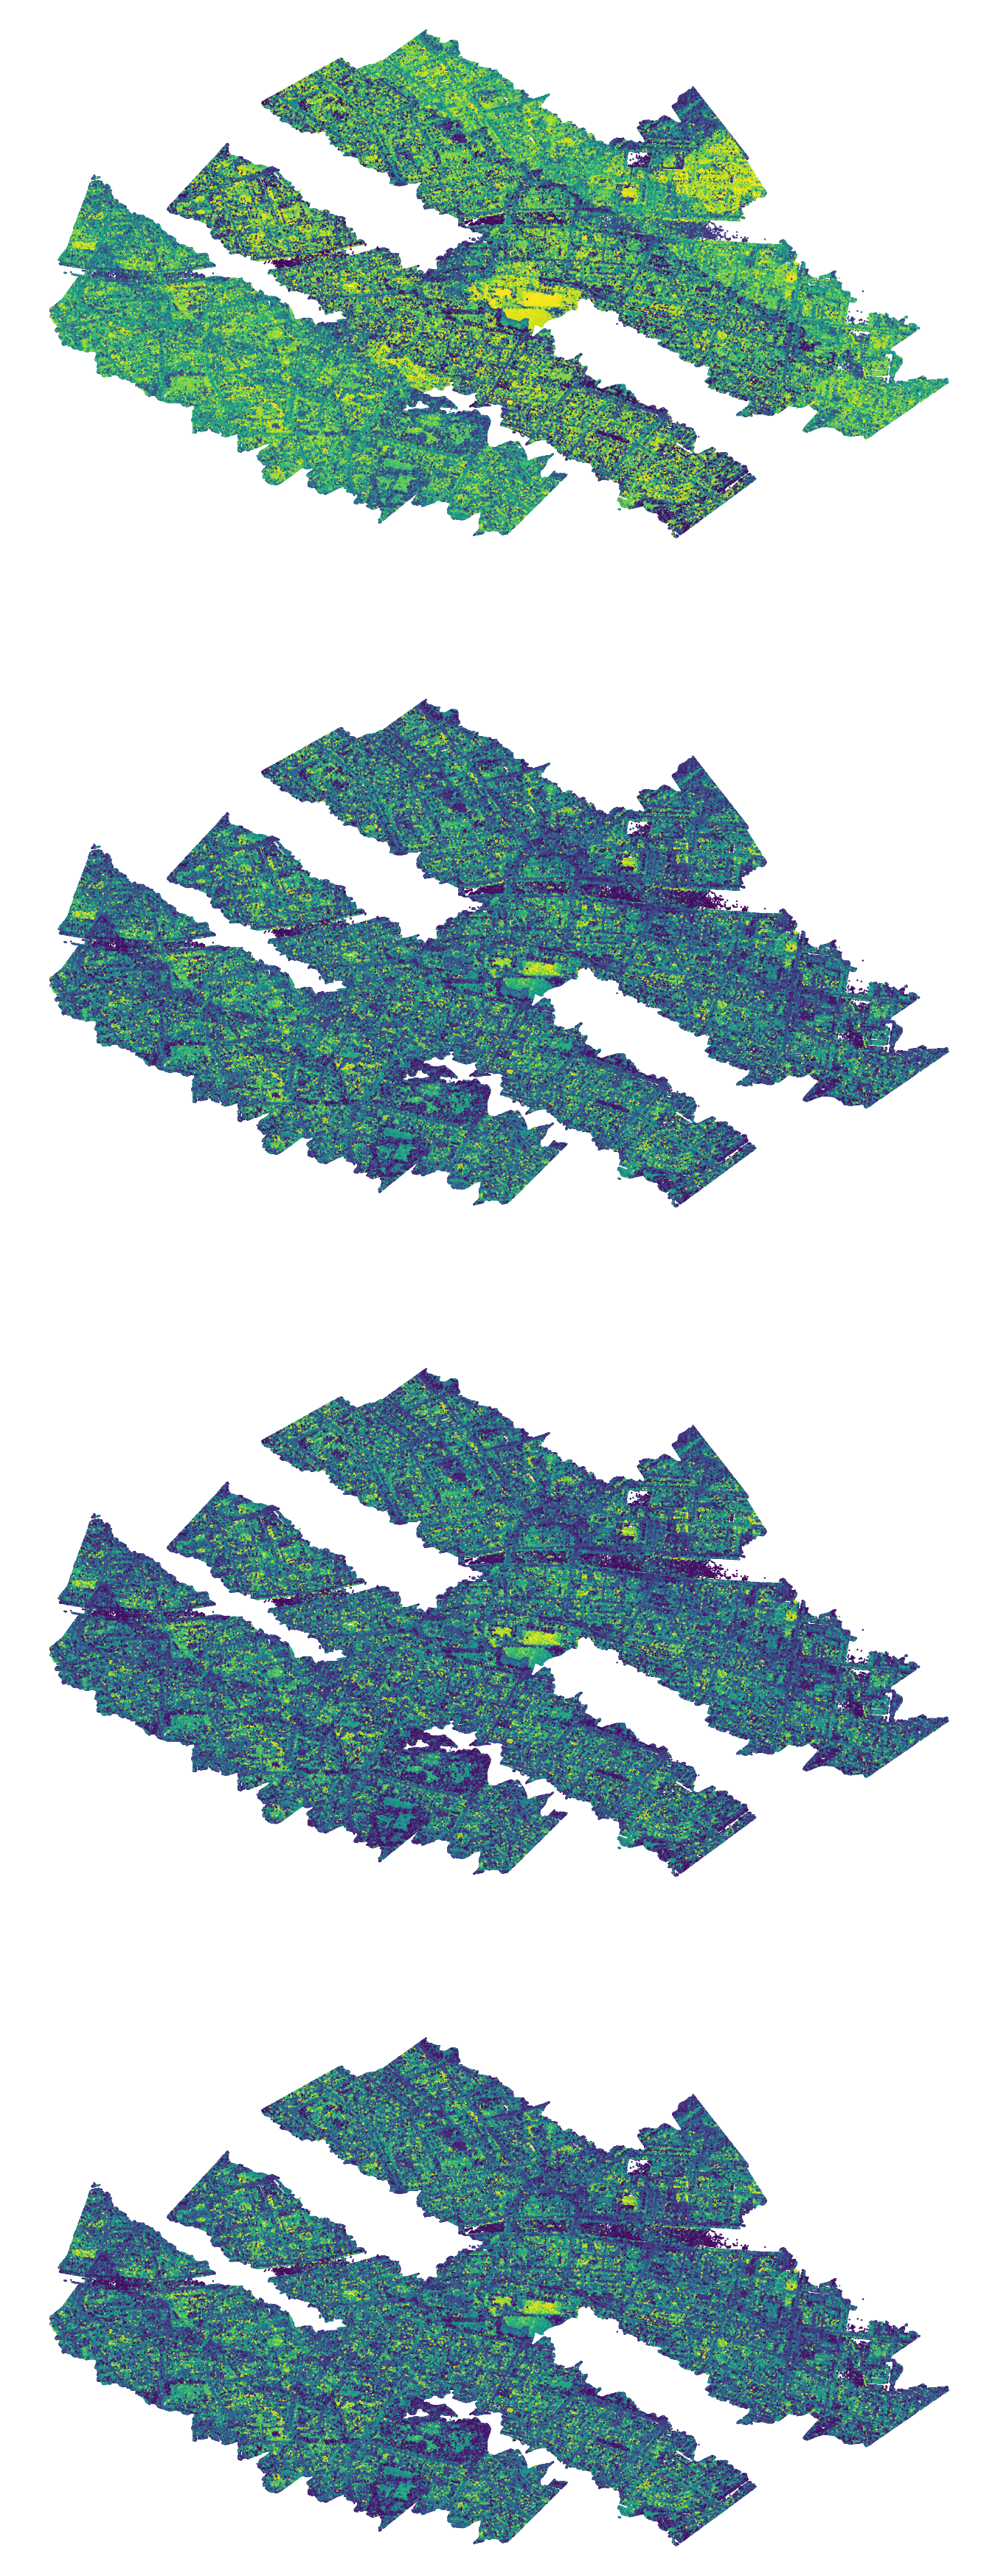

MAPE: 0.02535


In [60]:
# plot these
fig, ax = plt.subplots(4, 1)
order = [4, 5, 3]
titles = ["alt", "gt", "fix", "checker"]
matplotlib.rcParams['figure.figsize'] = [24, 64]

for i in range(0, 3):
    ax.flat[i].scatter(full_scan[:, 0], full_scan[:, 1], s=2, c=full_scan[:, order[i]], vmin=0, vmax=512)
    print(titles[i])
    ax.flat[i].axis("off")
    
cb_t1, cb_t2 = checkerboard(full_scan, full_scan)
print("checkerboard")
ax.flat[3].scatter(cb_t1[:, 0], cb_t1[:, 1], c=cb_t1[:, 3], s=2, vmin=0, vmax=512)
ax.flat[3].scatter(cb_t2[:, 0], cb_t2[:, 1], c=cb_t2[:, 5], s=2, vmin=0, vmax=512)
ax.flat[3].axis("off")
    
plt.show()
mae = np.mean(np.abs(full_scan[:, 5] - full_scan[:, 3]))
print(f"MAE: {mae/512:.5f}")
